In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Load the data**

In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\abalone\abalone.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
print(Xy['data'])

[[1.     0.455  0.365  ... 0.2245 0.101  0.15  ]
 [1.     0.35   0.265  ... 0.0995 0.0485 0.07  ]
 [2.     0.53   0.42   ... 0.2565 0.1415 0.21  ]
 ...
 [1.     0.6    0.475  ... 0.5255 0.2875 0.308 ]
 [2.     0.625  0.485  ... 0.531  0.261  0.296 ]
 [1.     0.71   0.555  ... 0.9455 0.3765 0.495 ]]


In [5]:
ground_truth_numpy = scale(Xy['data']) #only taking the features
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [6]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

23.683286999085876
-3.739153672082058
1.7648745232250513e-17
0.053798148190197605
1.0


In [7]:
print(ground_truth_numpy[1])

[-1.15434629 -1.44898585 -1.439929   -1.18397831 -1.23027711 -1.17090984
 -1.20522124 -1.21298732]


In [8]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(4177, 8)
tensor(0)


**Creating missing values**

In [9]:

#10% MCAR

np.random.seed(42)

p_macr10 = 0.09368


mask_mcar10 = np.random.rand(*ground_truth.shape) < p_macr10  # True for missing values, false for others
data_mcar10 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar10[mask_mcar10] = np.nan

# Convert to a torch tensor
data_mcar10 = torch.from_numpy(data_mcar10)

# Calculate the percentage of missing values
missing_values_mcar10 = torch.isnan(data_mcar10)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar10 = torch.sum(missing_values_mcar10).item() / data_mcar10.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar10:.2f}%")


Percentage of missing values: 9.46%


In [10]:
#15% MCAR

np.random.seed(42)

p_macr15 = 0.13931


mask_mcar15 = np.random.rand(*ground_truth.shape) < p_macr15  # True for missing values, false for others
data_mcar15 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar15[mask_mcar15] = np.nan

# Convert to a torch tensor
data_mcar15 = torch.from_numpy(data_mcar15)

# Calculate the percentage of missing values
missing_values_mcar15 = torch.isnan(data_mcar15)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar15 = torch.sum(missing_values_mcar15).item() / data_mcar15.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar15:.2f}%")

Percentage of missing values: 13.95%


In [11]:
#20% MCAR
np.random.seed(42)

p_macr20 = 0.1853


mask_mcar20 = np.random.rand(*ground_truth.shape) < p_macr20  # True for missing values, false for others
data_mcar20 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar20[mask_mcar20] = np.nan

# Convert to a torch tensor
data_mcar20 = torch.from_numpy(data_mcar20)

# Calculate the percentage of missing values
missing_values_mcar20 = torch.isnan(data_mcar20)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar20 = torch.sum(missing_values_mcar20).item() / data_mcar20.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar20:.2f}%")

Percentage of missing values: 18.40%


In [12]:
#25% MCAR
np.random.seed(42)

p_macr25 = 0.2403


mask_mcar25 = np.random.rand(*ground_truth.shape) < p_macr25  # True for missing values, false for others
data_mcar25 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar25[mask_mcar25] = np.nan

# Convert to a torch tensor
data_mcar25 = torch.from_numpy(data_mcar25)

# Calculate the percentage of missing values
missing_values_mcar25 = torch.isnan(data_mcar25)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar25 = torch.sum(missing_values_mcar25).item() / data_mcar25.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar25:.2f}%")

Percentage of missing values: 24.00%


In [13]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.2929


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 29.19%


In [14]:
#35% MCAR
np.random.seed(42)

p_macr35 = 0.3479


mask_mcar35 = np.random.rand(*ground_truth.shape) < p_macr35  # True for missing values, false for others
data_mcar35 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar35[mask_mcar35] = np.nan

# Convert to a torch tensor
data_mcar35 = torch.from_numpy(data_mcar35)

# Calculate the percentage of missing values
missing_values_mcar35 = torch.isnan(data_mcar35)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar35 = torch.sum(missing_values_mcar35).item() / data_mcar35.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar35:.2f}%")

Percentage of missing values: 34.74%


In [15]:
#40% MCAR
np.random.seed(42)

p_macr40 = 0.3999


mask_mcar40 = np.random.rand(*ground_truth.shape) < p_macr40  # True for missing values, false for others
data_mcar40 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar40[mask_mcar40] = np.nan

# Convert to a torch tensor
data_mcar40 = torch.from_numpy(data_mcar40)

# Calculate the percentage of missing values
missing_values_mcar40 = torch.isnan(data_mcar40)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar40 = torch.sum(missing_values_mcar40).item() / data_mcar40.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar40:.2f}%")

Percentage of missing values: 39.93%


In [16]:
#45% MCAR
np.random.seed(42)

p_macr45 = 0.456


mask_mcar45 = np.random.rand(*ground_truth.shape) < p_macr45  # True for missing values, false for others
data_mcar45 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar45[mask_mcar45] = np.nan

# Convert to a torch tensor
data_mcar45 = torch.from_numpy(data_mcar45)

# Calculate the percentage of missing values
missing_values_mcar45 = torch.isnan(data_mcar45)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar45 = torch.sum(missing_values_mcar45).item() / data_mcar45.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar45:.2f}%")

Percentage of missing values: 45.64%


In [17]:
#50% MCAR
np.random.seed(42)

p_macr50 = 0.508


mask_mcar50 = np.random.rand(*ground_truth.shape) < p_macr50  # True for missing values, false for others
data_mcar50 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar50[mask_mcar50] = np.nan

# Convert to a torch tensor
data_mcar50 = torch.from_numpy(data_mcar50)

# Calculate the percentage of missing values
missing_values_mcar50 = torch.isnan(data_mcar50)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar50 = torch.sum(missing_values_mcar50).item() / data_mcar50.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar50:.2f}%")

Percentage of missing values: 50.83%


In [18]:
#60% MCAR
np.random.seed(42)

p_macr60 = 0.60775


mask_mcar60 = np.random.rand(*ground_truth.shape) < p_macr60  # True for missing values, false for others
data_mcar60 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar60[mask_mcar60] = np.nan

# Convert to a torch tensor
data_mcar60 = torch.from_numpy(data_mcar60)

# Calculate the percentage of missing values
missing_values_mcar60 = torch.isnan(data_mcar60)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar60 = torch.sum(missing_values_mcar60).item() / data_mcar60.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar60:.2f}%")

Percentage of missing values: 60.78%


In [19]:
#70 MCAR
np.random.seed(42)

p_macr70 = 0.70


mask_mcar70 = np.random.rand(*ground_truth.shape) < p_macr70  # True for missing values, false for others
data_mcar70 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar70[mask_mcar70] = np.nan

# Convert to a torch tensor
data_mcar70 = torch.from_numpy(data_mcar70)

# Calculate the percentage of missing values
missing_values_mcar70 = torch.isnan(data_mcar70)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar70 = torch.sum(missing_values_mcar70).item() / data_mcar70.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar70:.2f}%")

Percentage of missing values: 70.24%


In [20]:
#80% MCAR
np.random.seed(42)

p_macr80 = 0.8026


mask_mcar80 = np.random.rand(*ground_truth.shape) < p_macr80  # True for missing values, false for others
data_mcar80 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar80[mask_mcar80] = np.nan

# Convert to a torch tensor
data_mcar80 = torch.from_numpy(data_mcar80)

# Calculate the percentage of missing values
missing_values_mcar80 = torch.isnan(data_mcar80)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar80 = torch.sum(missing_values_mcar80).item() / data_mcar80.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar80:.2f}%")

Percentage of missing values: 80.31%


In [21]:
#90% MCAR
np.random.seed(42)

p_macr90 = 0.9


mask_mcar90 = np.random.rand(*ground_truth.shape) < p_macr90  # True for missing values, false for others
data_mcar90 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar90[mask_mcar90] = np.nan

# Convert to a torch tensor
data_mcar90 = torch.from_numpy(data_mcar90)

# Calculate the percentage of missing values
missing_values_mcar90 = torch.isnan(data_mcar90)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar90 = torch.sum(missing_values_mcar90).item() / data_mcar90.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar90:.2f}%")

Percentage of missing values: 90.01%


In [22]:
#95% MCAR
np.random.seed(42)

p_macr95 = 0.951


mask_mcar95 = np.random.rand(*ground_truth.shape) < p_macr95  # True for missing values, false for others
data_mcar95 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar95[mask_mcar95] = np.nan

# Convert to a torch tensor
data_mcar95 = torch.from_numpy(data_mcar95)

# Calculate the percentage of missing values
missing_values_mcar95 = torch.isnan(data_mcar95)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar95 = torch.sum(missing_values_mcar95).item() / data_mcar95.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar95:.2f}%")

Percentage of missing values: 95.10%


In [23]:
#%100 MCAR
np.random.seed(42)

p_macr100 = 1


mask_mcar100 = np.random.rand(*ground_truth.shape) < p_macr100  # True for missing values, false for others
data_mcar100 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar100[mask_mcar100] = np.nan

# Convert to a torch tensor
data_mcar100 = torch.from_numpy(data_mcar100)

# Calculate the percentage of missing values
missing_values_mcar100 = torch.isnan(data_mcar100)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar100 = torch.sum(missing_values_mcar100).item() / data_mcar100.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar100:.2f}%")

Percentage of missing values: 100.00%


In [24]:
data_mcar10_numpy = data_mcar10.detach().cpu().numpy()
data_mcar15_numpy = data_mcar15.detach().cpu().numpy()
data_mcar20_numpy = data_mcar20.detach().cpu().numpy()
data_mcar25_numpy = data_mcar25.detach().cpu().numpy()
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()
data_mcar35_numpy = data_mcar35.detach().cpu().numpy()
data_mcar40_numpy = data_mcar40.detach().cpu().numpy()
data_mcar45_numpy = data_mcar45.detach().cpu().numpy()
data_mcar50_numpy = data_mcar50.detach().cpu().numpy()
data_mcar60_numpy = data_mcar60.detach().cpu().numpy()
data_mcar70_numpy = data_mcar70.detach().cpu().numpy()
data_mcar80_numpy = data_mcar80.detach().cpu().numpy()
data_mcar90_numpy = data_mcar90.detach().cpu().numpy()
data_mcar95_numpy = data_mcar95.detach().cpu().numpy()
data_mcar100_numpy = data_mcar100.detach().cpu().numpy()

**10% MCAR**

In [25]:
n_mcar10, d_mcar10 = data_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(data_mcar10)
print(epsilon_mcar10)

0.2158862673026275


In [26]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=2000)

In [27]:
sk_imp_mcar10, sk_maes10mcar, sk_rmses10mcar = sk_imputer_mcar10.fit_transform(data_mcar10, verbose=True, report_interval=500, X_true=ground_truth.clone())

INFO:root:batchsize = 128, epsilon = 0.2159
INFO:root:Iteration 0:	 Loss: 2.3736	 Validation MAE: 0.8137	RMSE: 0.9979
INFO:root:Iteration 500:	 Loss: 0.5553	 Validation MAE: 0.3869	RMSE: 0.5725
INFO:root:Iteration 1000:	 Loss: 0.4481	 Validation MAE: 0.2894	RMSE: 0.4696
INFO:root:Iteration 1500:	 Loss: 0.2964	 Validation MAE: 0.2749	RMSE: 0.4510


In [28]:
#using numpy version of data
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()

In [29]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.26930972477190335 0.44743977717756916


In [30]:
#mean
#using numpy version of data
mean_imp_mcar10 = SimpleImputer().fit_transform(data_mcar10_numpy)
mean_mae_mcar10 = MAE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.8082114768860635 0.991241567949823


In [31]:
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar10_numpy)
ice_mae_mcar10 = MAE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.2182546559217716 0.38441700487185443


In [32]:
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(data_mcar10_numpy, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((data_mcar10_numpy), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.2582005713637339 0.4092983758114628


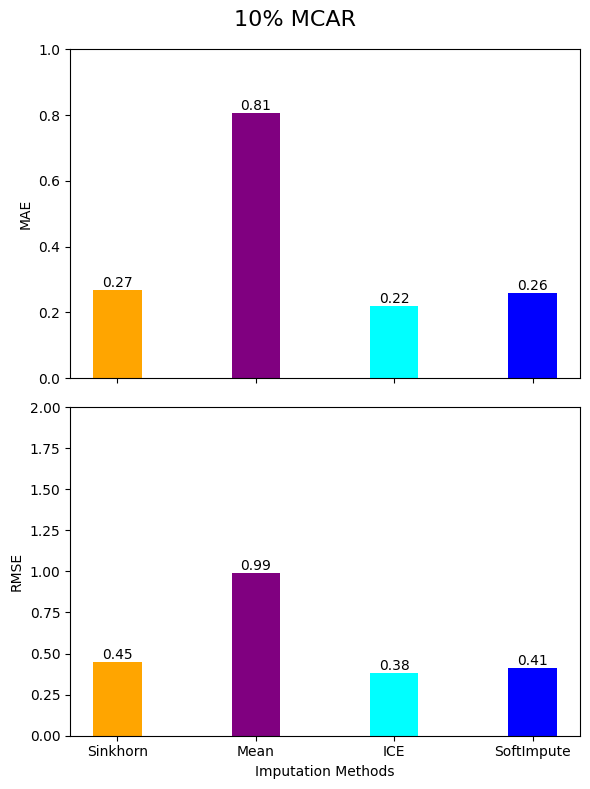

In [33]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


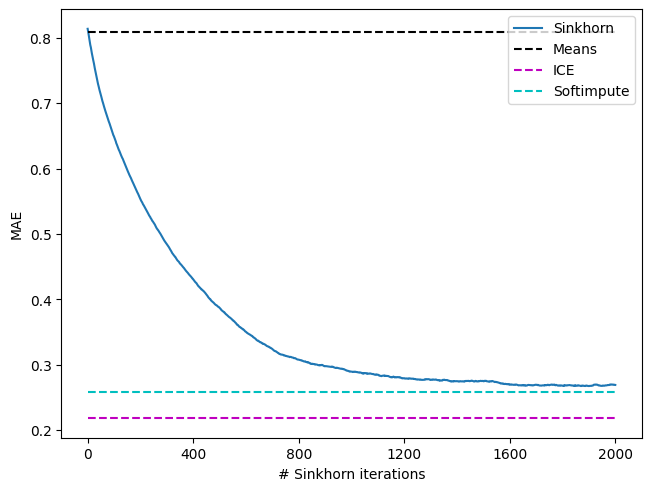

In [34]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes10mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes10mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

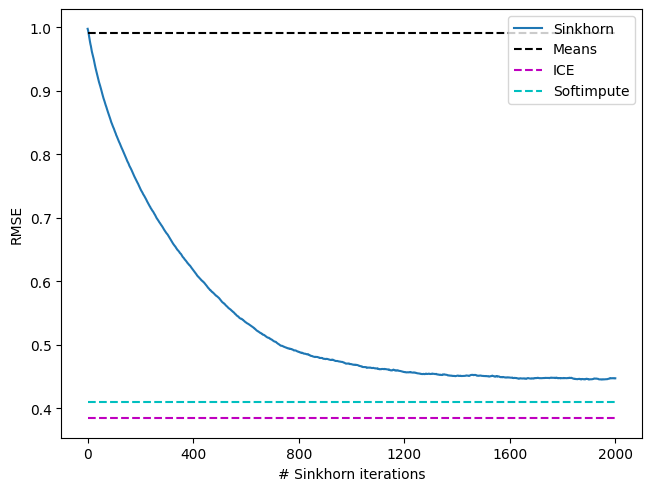

In [35]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses10mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses10mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**15% MCAR**

In [36]:
#sinkhorn
n_mcar15, d_mcar15 = data_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(data_mcar15)

print(epsilon_mcar15)

sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes15mcar, sk_rmses15mcar = sk_imputer_mcar15.fit_transform(data_mcar15, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()

sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

INFO:root:batchsize = 128, epsilon = 0.2078


0.20780266842256065


INFO:root:Iteration 0:	 Loss: 2.5819	 Validation MAE: 0.8125	RMSE: 0.9974
INFO:root:Iteration 500:	 Loss: 0.3169	 Validation MAE: 0.3950	RMSE: 0.5823
INFO:root:Iteration 1000:	 Loss: 0.3011	 Validation MAE: 0.2926	RMSE: 0.4732
INFO:root:Iteration 1500:	 Loss: 0.4289	 Validation MAE: 0.2699	RMSE: 0.4435


0.26781994853559676 0.43891249922704656


In [37]:
#mean
#using numpy version of data
mean_imp_mcar15 = SimpleImputer().fit_transform(data_mcar15_numpy)
mean_mae_mcar15 = MAE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

#ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar15_numpy)
ice_mae_mcar15 = MAE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#SoftImpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(data_mcar15_numpy, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((data_mcar15_numpy), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)



0.8104689537641196 0.9937552196260674
0.22075310139835694 0.38146995898389546
0.2613198074361924 0.40966864071889997


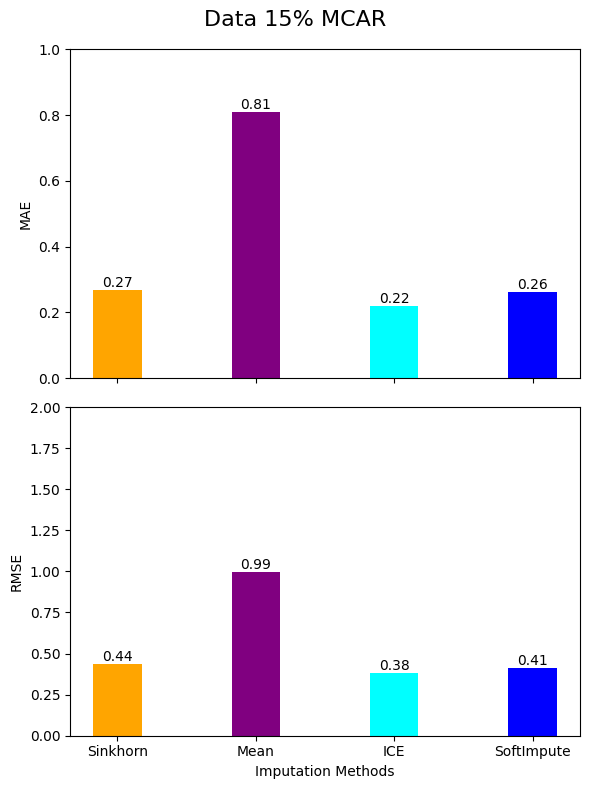

In [38]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


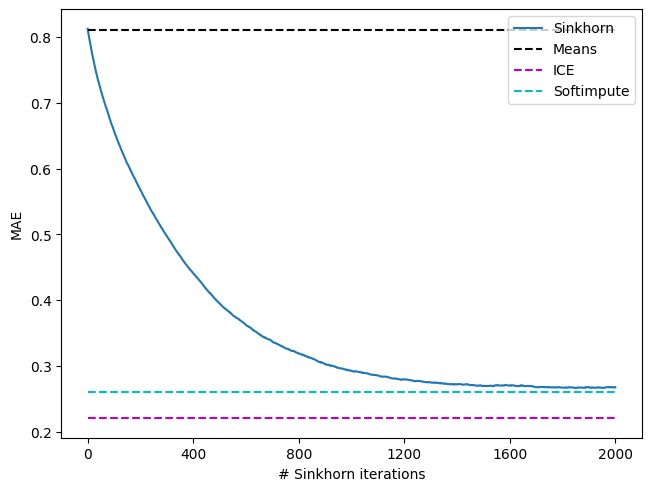

In [39]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes15mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes15mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar15, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar15, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar15, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

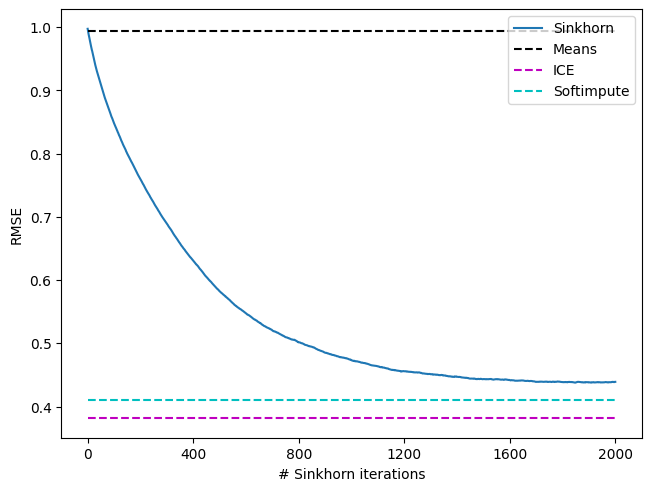

In [40]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses15mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses15mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar15, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar15, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar15, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**20% MCAR**

In [41]:
#sinkhorn
n_mcar20, d_mcar20 = data_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(data_mcar20)

print(epsilon_mcar20)

sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes20mcar, sk_rmses20mcar = sk_imputer_mcar20.fit_transform(data_mcar20, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()

sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

INFO:root:batchsize = 128, epsilon = 0.2012


0.20118372968607778


INFO:root:Iteration 0:	 Loss: 0.7897	 Validation MAE: 0.8159	RMSE: 1.0001
INFO:root:Iteration 500:	 Loss: 0.4846	 Validation MAE: 0.4119	RMSE: 0.6013
INFO:root:Iteration 1000:	 Loss: 0.3339	 Validation MAE: 0.3039	RMSE: 0.4859
INFO:root:Iteration 1500:	 Loss: 0.3931	 Validation MAE: 0.2791	RMSE: 0.4530


0.27480055372234374 0.44957376562255824


In [42]:
#mean
#using numpy version of data
mean_imp_mcar20 = SimpleImputer().fit_transform(data_mcar20_numpy)
mean_mae_mcar20 = MAE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

#ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar20_numpy)
ice_mae_mcar20 = MAE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#SoftImpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(data_mcar20_numpy, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((data_mcar20_numpy), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.8098286790071466 0.9939831737775363
0.23074766984590633 0.3906232840689966
0.2701341132621772 0.4159496820176273


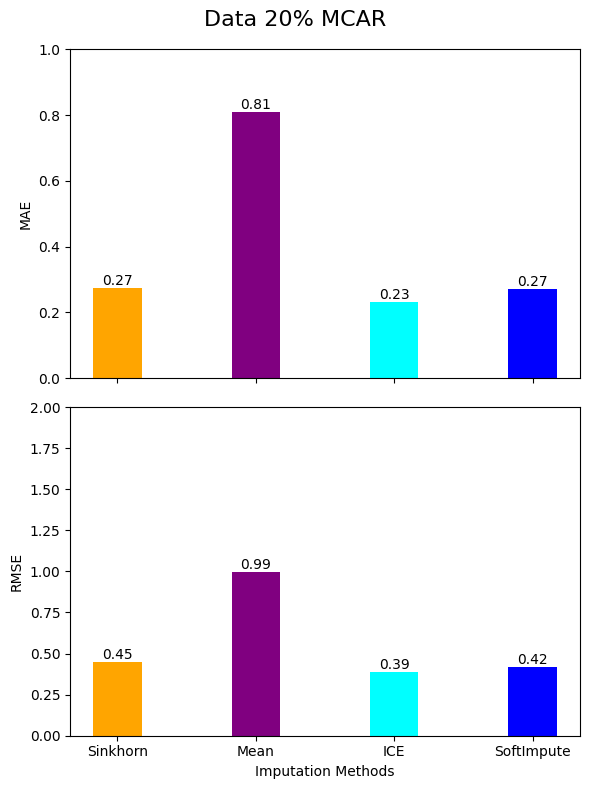

In [43]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


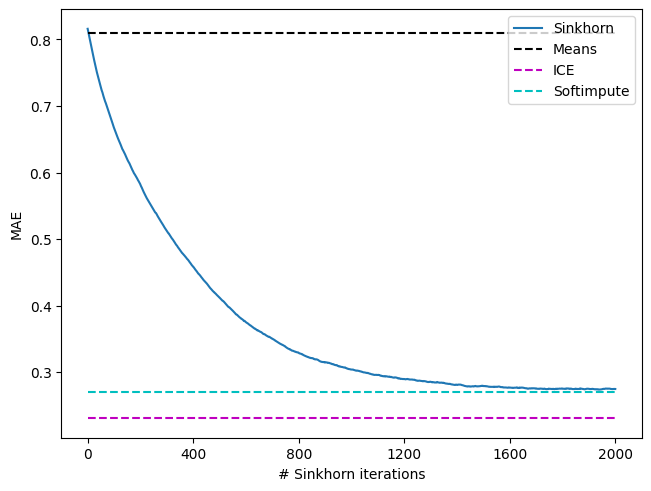

In [44]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes20mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes20mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar20, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar20, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar20, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

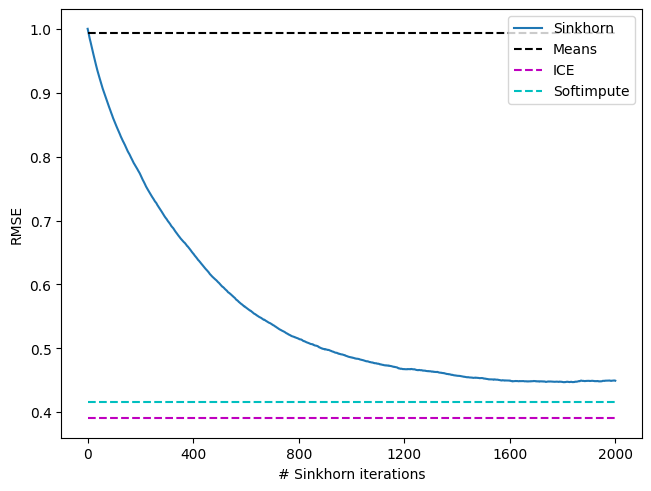

In [45]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses20mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses20mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar20, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar20, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar20, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**25% MCAR**

In [46]:
#sinkhorn
n_mcar25, d_mcar25 = data_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(data_mcar25)

print(epsilon_mcar25)

sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar = sk_imputer_mcar25.fit_transform(data_mcar25, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,ground_truth_numpy ,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

INFO:root:batchsize = 128, epsilon = 0.1949


0.19492989844495612


INFO:root:Iteration 0:	 Loss: 0.8144	 Validation MAE: 0.8115	RMSE: 0.9970
INFO:root:Iteration 500:	 Loss: 0.4892	 Validation MAE: 0.4211	RMSE: 0.6049
INFO:root:Iteration 1000:	 Loss: 2.1499	 Validation MAE: 0.3052	RMSE: 0.4829
INFO:root:Iteration 1500:	 Loss: 0.3586	 Validation MAE: 0.2788	RMSE: 0.4495


0.27235494661138676 0.4378983189164052


In [47]:
#mean
#using numpy version of data
mean_imp_mcar25 = SimpleImputer().fit_transform(data_mcar25_numpy)
mean_mae_mcar25 = MAE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

#ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar25_numpy)
ice_mae_mcar25 = MAE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#SoftImpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(data_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((data_mcar25_numpy), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.8062499246800218 0.9905146102972867
0.24009984531827167 0.39541232795475945
0.27438345204883613 0.41756695555261314


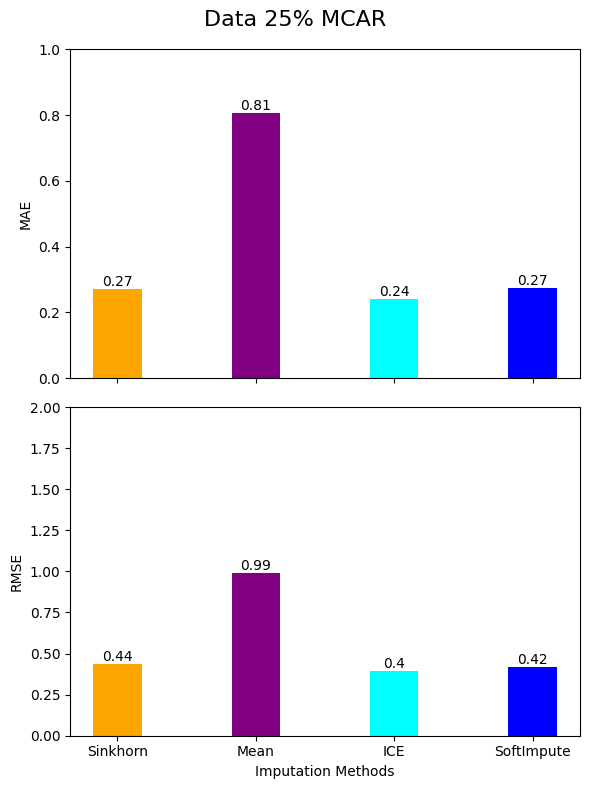

In [48]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


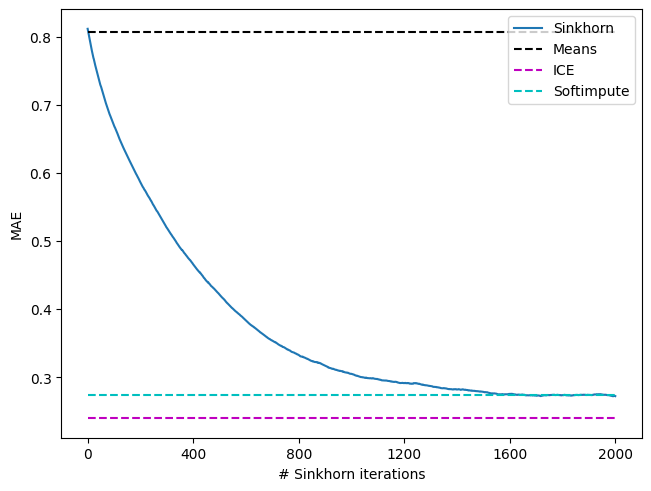

In [49]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes25mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes25mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar25, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar25, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar25, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

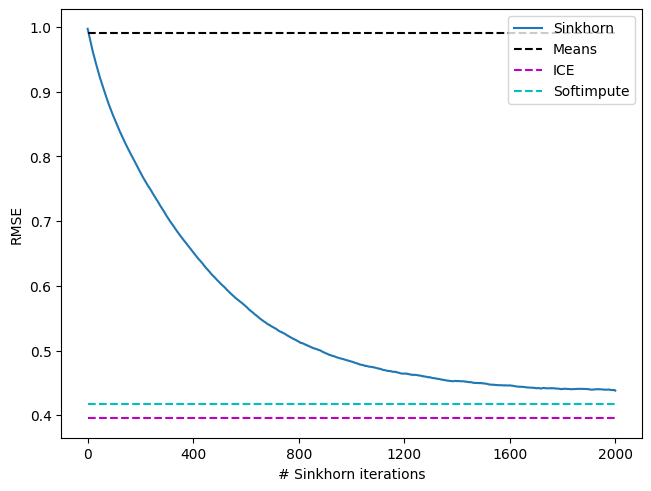

In [50]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses25mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses25mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar25, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar25, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar25, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**30% MCAR**

In [51]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:batchsize = 128, epsilon = 0.1905


0.19054134049138516


INFO:root:Iteration 0:	 Loss: 0.8720	 Validation MAE: 0.8148	RMSE: 0.9995
INFO:root:Iteration 500:	 Loss: 0.5342	 Validation MAE: 0.4341	RMSE: 0.6213
INFO:root:Iteration 1000:	 Loss: 0.3635	 Validation MAE: 0.3147	RMSE: 0.4934
INFO:root:Iteration 1500:	 Loss: 0.4358	 Validation MAE: 0.2856	RMSE: 0.4547


0.2766020630450307 0.442627025360002


In [52]:
#mean
#using numpy version of data
mean_imp_mcar30 = SimpleImputer().fit_transform(data_mcar30_numpy)
mean_mae_mcar30 = MAE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
mean_rmse_mcar30= RMSE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

#ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar30_numpy)
ice_mae_mcar30 = MAE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(ice_mae_mcar30,ice_rmse_mcar30)

#SoftImpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(data_mcar30_numpy, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((data_mcar30_numpy), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.8089042826080399 0.9934619950898003
0.25752939298773736 0.42787252637950174
0.28421131425841073 0.42716792797768216


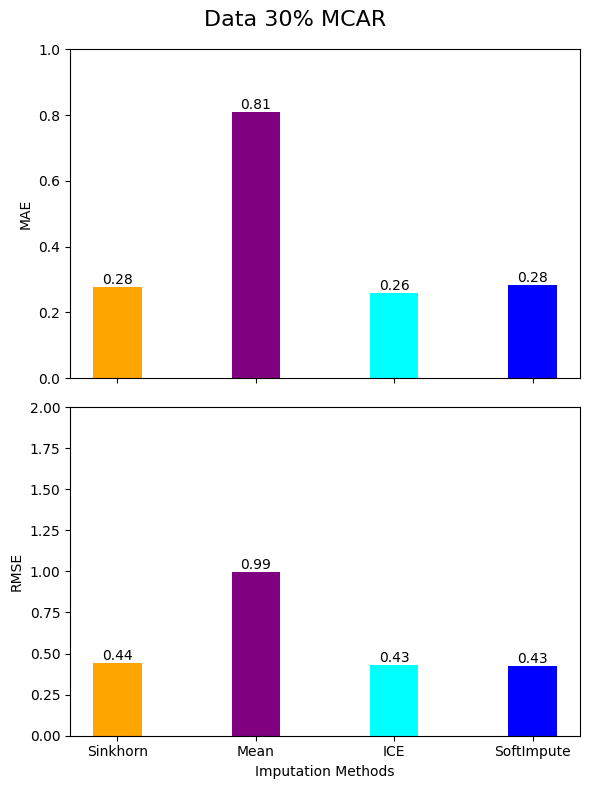

In [53]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


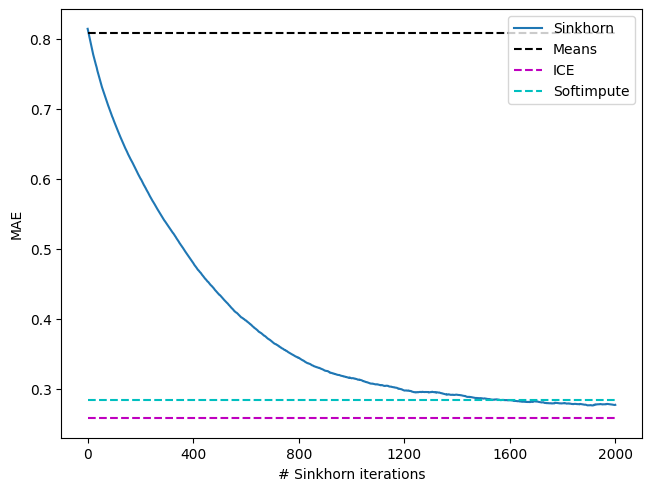

In [54]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar30, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar30, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar30, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

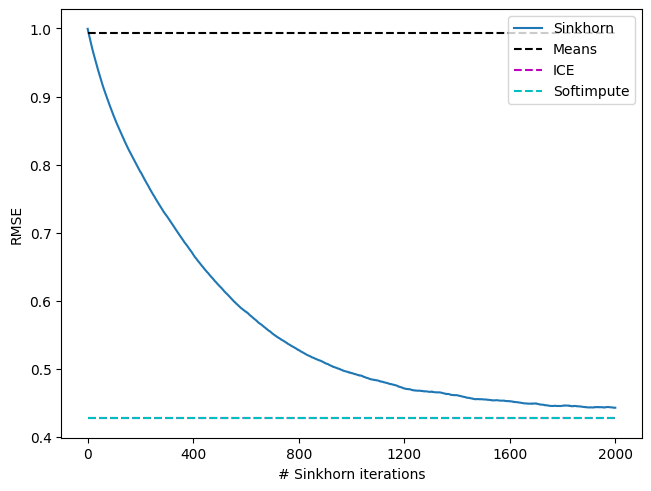

In [55]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar30, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar30, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar30, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**35% MCAR**

In [56]:
#sinkhorn
n_mcar35, d_mcar35 = data_mcar35.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar35 = pick_epsilon(data_mcar35)

print(epsilon_mcar35)

sk_imputer_mcar35 = SinkhornImputation(eps=epsilon_mcar35, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar35, sk_maes35mcar, sk_rmses35mcar = sk_imputer_mcar35.fit_transform(data_mcar35, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar35_numpy = sk_imp_mcar35.detach().cpu().numpy()

sk_mae_mcar35 = MAE(sk_imp_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
sk_rmse_mcar35 = RMSE(sk_imp_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(sk_mae_mcar35,sk_rmse_mcar35)

INFO:root:batchsize = 128, epsilon = 0.1749


0.17488907012316557


INFO:root:Iteration 0:	 Loss: 0.8717	 Validation MAE: 0.8145	RMSE: 1.0004
INFO:root:Iteration 500:	 Loss: 2.3128	 Validation MAE: 0.4529	RMSE: 0.6388
INFO:root:Iteration 1000:	 Loss: 0.3013	 Validation MAE: 0.3283	RMSE: 0.5090
INFO:root:Iteration 1500:	 Loss: 0.5396	 Validation MAE: 0.2961	RMSE: 0.4662


0.2837883172856218 0.4504671530188814


In [57]:
#mean
#using numpy version of data
mean_imp_mcar35 = SimpleImputer().fit_transform(data_mcar35_numpy)
mean_mae_mcar35 = MAE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
mean_rmse_mcar35 = RMSE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(mean_mae_mcar35, mean_rmse_mcar35)

#ICE
ice_imp_mcar35 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar35_numpy)
ice_mae_mcar35 = MAE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
ice_rmse_mcar35 = RMSE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(ice_mae_mcar35,ice_rmse_mcar35)

#SoftImpute
cv_error_mcar35, grid_lambda_mcar35 = cv_softimpute(data_mcar35_numpy, grid_len=15)
lbda_mcar35 = grid_lambda_mcar35[np.argmin(cv_error_mcar35)]
soft_imp_mcar35 = softimpute((data_mcar35_numpy), lbda_mcar35)[1]

soft_mae_mcar35 = MAE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
soft_rmse_mcar35 = RMSE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(soft_mae_mcar35,soft_rmse_mcar35)

0.809616549651965 0.9950643230027442
0.2807708910534877 0.46324542537409574
0.29523048905762134 0.4409757896855655


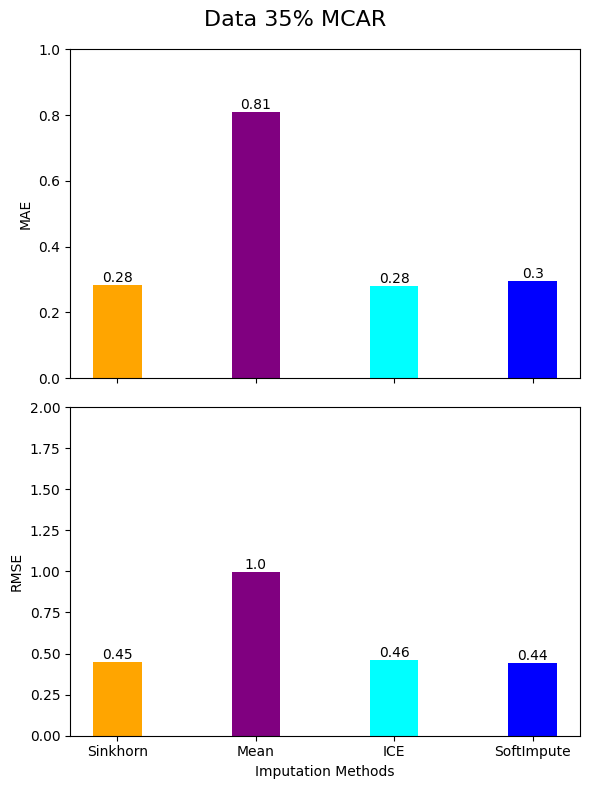

In [58]:

# Define values and categories
values_mae_mcar35 = [sk_mae_mcar35, mean_mae_mcar35, ice_mae_mcar35, soft_mae_mcar35]
values_rmse_mcar35 = [sk_rmse_mcar35, mean_rmse_mcar35, ice_rmse_mcar35, soft_rmse_mcar35]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


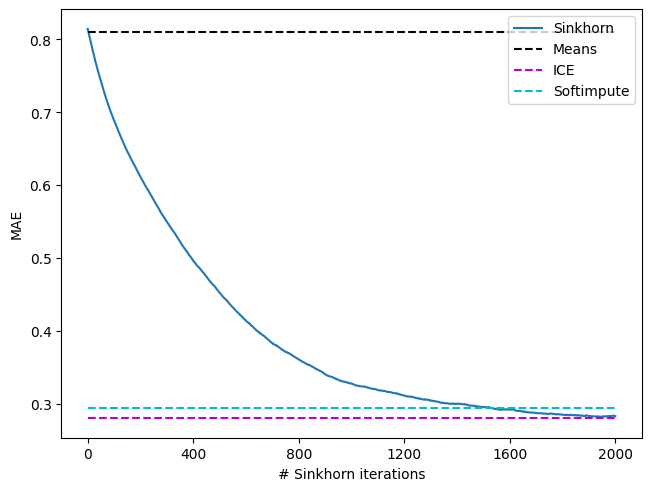

In [59]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes35mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes35mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar35, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar35, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar35, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

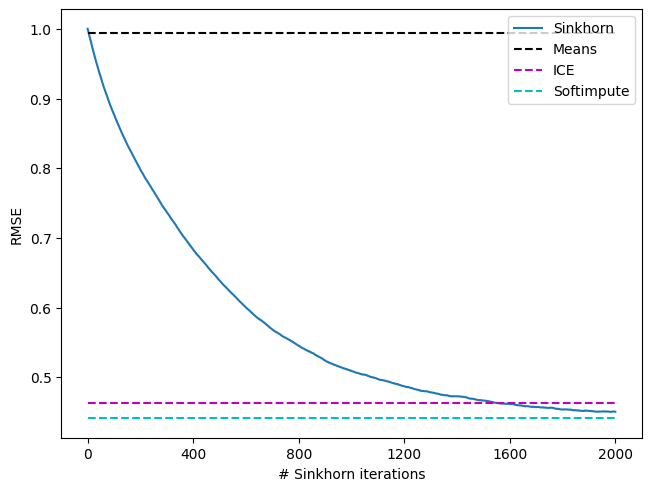

In [60]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses35mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses35mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar35, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar35, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar35, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**40% MCAR**

In [61]:
#sinkhorn
n_mcar40, d_mcar40 = data_mcar40.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar40 = pick_epsilon(data_mcar40)

print(epsilon_mcar40)

sk_imputer_mcar40 = SinkhornImputation(eps=epsilon_mcar40, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar40, sk_maes40mcar, sk_rmses40mcar = sk_imputer_mcar40.fit_transform(data_mcar40, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar40_numpy = sk_imp_mcar40.detach().cpu().numpy()

sk_mae_mcar40 = MAE(sk_imp_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
sk_rmse_mcar40 = RMSE(sk_imp_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(sk_mae_mcar40,sk_rmse_mcar40)

INFO:root:batchsize = 128, epsilon = 0.1619


0.16188464881636555


INFO:root:Iteration 0:	 Loss: 1.1250	 Validation MAE: 0.8110	RMSE: 0.9960
INFO:root:Iteration 500:	 Loss: 0.3961	 Validation MAE: 0.4673	RMSE: 0.6519
INFO:root:Iteration 1000:	 Loss: 0.4591	 Validation MAE: 0.3421	RMSE: 0.5228
INFO:root:Iteration 1500:	 Loss: 0.2754	 Validation MAE: 0.3044	RMSE: 0.4755


0.2901035153675933 0.45639639281983563


In [62]:
#mean
#using numpy version of data
mean_imp_mcar40 = SimpleImputer().fit_transform(data_mcar40_numpy)
mean_mae_mcar40 = MAE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
mean_rmse_mcar40= RMSE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(mean_mae_mcar40, mean_rmse_mcar40)

#ICE
ice_imp_mcar40 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar40_numpy)
ice_mae_mcar40 = MAE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
ice_rmse_mcar40 = RMSE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(ice_mae_mcar40,ice_rmse_mcar40)

#SoftImpute
cv_error_mcar40, grid_lambda_mcar40 = cv_softimpute(data_mcar40_numpy, grid_len=15)
lbda_mcar40 = grid_lambda_mcar40[np.argmin(cv_error_mcar40)]
soft_imp_mcar40 = softimpute((data_mcar40_numpy), lbda_mcar40)[1]

soft_mae_mcar40 = MAE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
soft_rmse_mcar40 = RMSE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(soft_mae_mcar40,soft_rmse_mcar40)

0.8077229357392853 0.9924094740765226
0.28073291967477143 0.45147757253962517
0.3042941397088504 0.4492556493869793


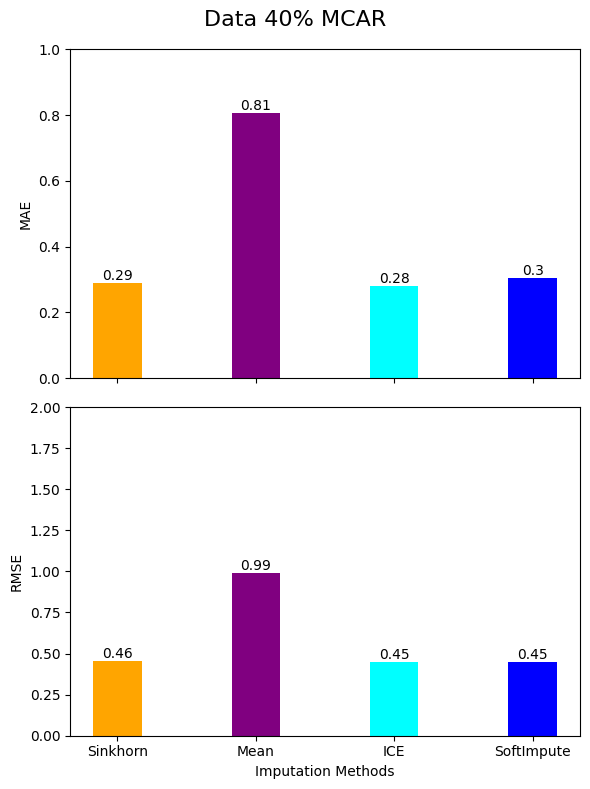

In [63]:

# Define values and categories
values_mae_mcar40 = [sk_mae_mcar40, mean_mae_mcar40, ice_mae_mcar40, soft_mae_mcar40]
values_rmse_mcar40 = [sk_rmse_mcar40, mean_rmse_mcar40, ice_rmse_mcar40, soft_rmse_mcar40]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar40, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar40, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


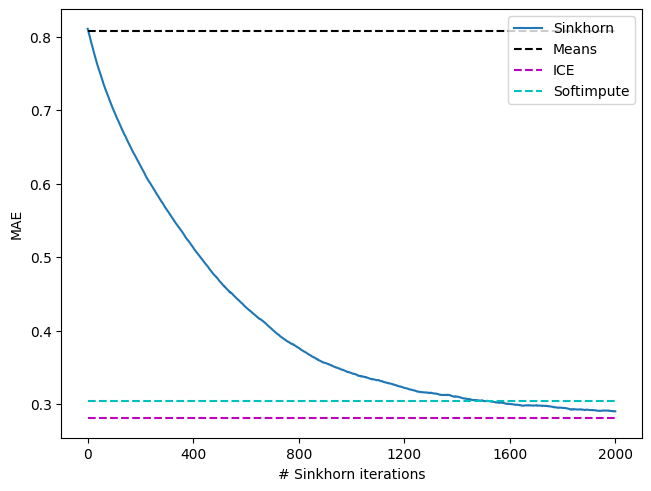

In [64]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes40mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes40mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar40, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar40, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar40, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

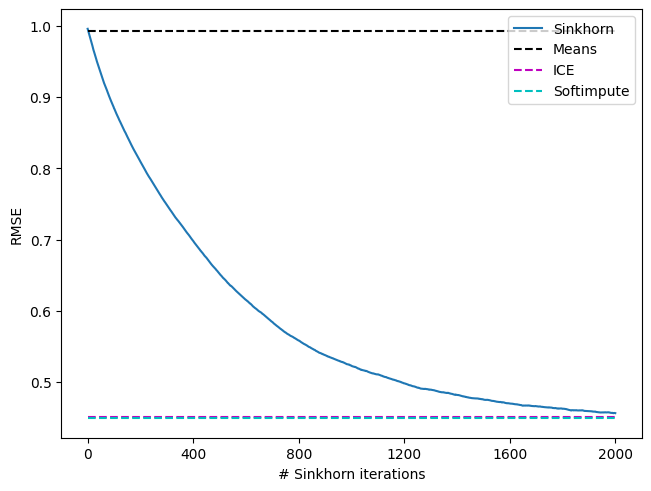

In [65]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses40mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses40mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar40, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar40, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar40, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**45% MCAR**

In [66]:
#sinkhorn
n_mcar45, d_mcar45 = data_mcar45.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar45 = pick_epsilon(data_mcar45)

print(epsilon_mcar45)

sk_imputer_mcar45 = SinkhornImputation(eps=epsilon_mcar45, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar45, sk_maes45mcar, sk_rmses45mcar = sk_imputer_mcar45.fit_transform(data_mcar45, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar45_numpy = sk_imp_mcar45.detach().cpu().numpy()

sk_mae_mcar45 = MAE(sk_imp_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
sk_rmse_mcar45 = RMSE(sk_imp_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(sk_mae_mcar45,sk_rmse_mcar45)

INFO:root:batchsize = 128, epsilon = 0.1463


0.14633797007937197


INFO:root:Iteration 0:	 Loss: 0.8608	 Validation MAE: 0.8129	RMSE: 0.9990
INFO:root:Iteration 500:	 Loss: 0.4875	 Validation MAE: 0.4932	RMSE: 0.6781
INFO:root:Iteration 1000:	 Loss: 0.6440	 Validation MAE: 0.3618	RMSE: 0.5466
INFO:root:Iteration 1500:	 Loss: 0.5326	 Validation MAE: 0.3191	RMSE: 0.4969


0.303869360691656 0.4768610651470473


In [67]:
#mean
#using numpy version of data
mean_imp_mcar45 = SimpleImputer().fit_transform(data_mcar45_numpy)
mean_mae_mcar45 = MAE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
mean_rmse_mcar45= RMSE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(mean_mae_mcar45, mean_rmse_mcar45)

#ICE
ice_imp_mcar45 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar45_numpy)
ice_mae_mcar45 = MAE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
ice_rmse_mcar45 = RMSE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(ice_mae_mcar45,ice_rmse_mcar45)

#SoftImpute
cv_error_mcar45, grid_lambda_mcar45 = cv_softimpute(data_mcar45_numpy, grid_len=15)
lbda_mcar45 = grid_lambda_mcar45[np.argmin(cv_error_mcar45)]
soft_imp_mcar45 = softimpute((data_mcar45_numpy), lbda_mcar45)[1]

soft_mae_mcar45 = MAE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
soft_rmse_mcar45 = RMSE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(soft_mae_mcar45,soft_rmse_mcar45)

0.8077588159231202 0.9939084506003705
0.3085818534118624 0.4911459772856353
0.31791947240136736 0.4706296577292474


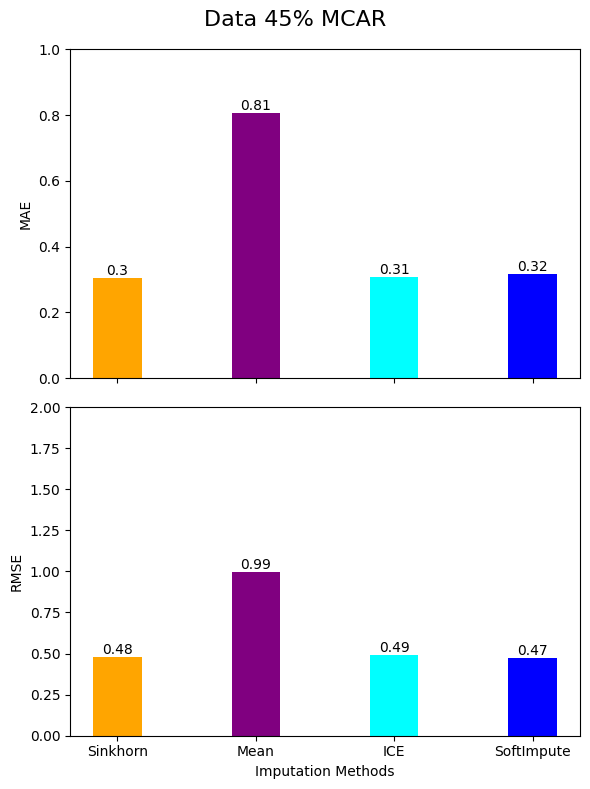

In [68]:

# Define values and categories
values_mae_mcar45 = [sk_mae_mcar45, mean_mae_mcar45, ice_mae_mcar45, soft_mae_mcar45]
values_rmse_mcar45 = [sk_rmse_mcar45, mean_rmse_mcar45, ice_rmse_mcar45, soft_rmse_mcar45]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


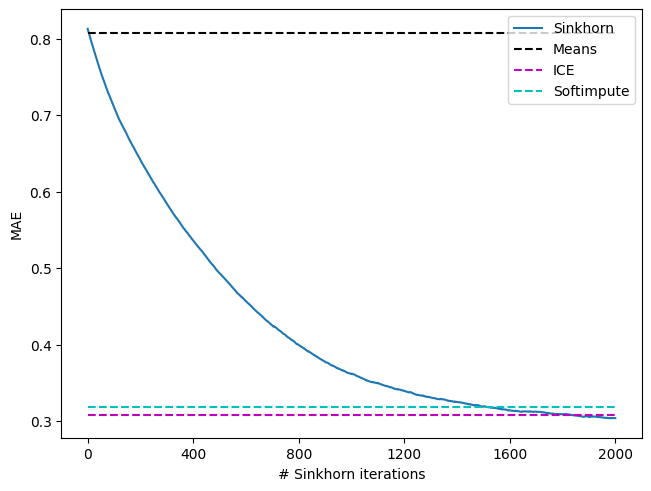

In [69]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes45mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes45mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar45, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar45, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar45, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

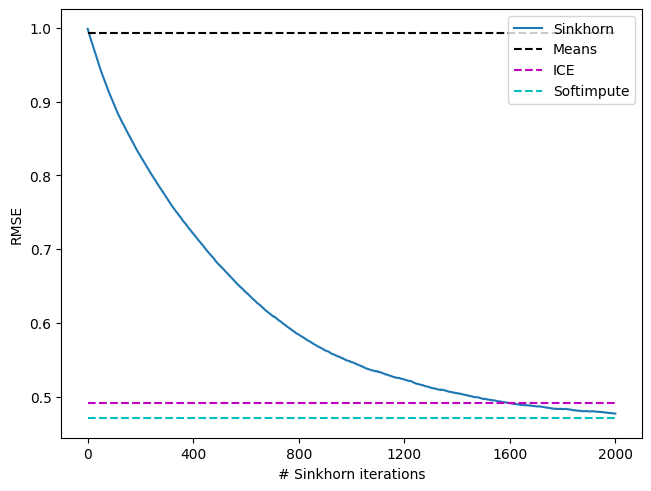

In [70]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses45mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses45mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar45, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar45, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar45, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

**50% MCAR**

In [71]:
#sinkhorn
n_mcar50, d_mcar50 = data_mcar50.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar50 = pick_epsilon(data_mcar50)

print(epsilon_mcar50)

sk_imputer_mcar50 = SinkhornImputation(eps=epsilon_mcar50, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar50, sk_maes50mcar, sk_rmses50mcar = sk_imputer_mcar50.fit_transform(data_mcar50, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar50_numpy = sk_imp_mcar50.detach().cpu().numpy()

sk_mae_mcar50 = MAE(sk_imp_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
sk_rmse_mcar50 = RMSE(sk_imp_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(sk_mae_mcar50,sk_rmse_mcar50)

INFO:root:batchsize = 128, epsilon = 0.1287


0.1286606026327692


INFO:root:Iteration 0:	 Loss: 0.9568	 Validation MAE: 0.8119	RMSE: 0.9968
INFO:root:Iteration 500:	 Loss: 0.5675	 Validation MAE: 0.5142	RMSE: 0.6972
INFO:root:Iteration 1000:	 Loss: 0.3246	 Validation MAE: 0.3814	RMSE: 0.5655
INFO:root:Iteration 1500:	 Loss: 0.2407	 Validation MAE: 0.3353	RMSE: 0.5141


0.3183290571311494 0.4936616842985395


In [72]:
#mean
#using numpy version of data
mean_imp_mcar50 = SimpleImputer().fit_transform(data_mcar50_numpy)
mean_mae_mcar50 = MAE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
mean_rmse_mcar50= RMSE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(mean_mae_mcar50, mean_rmse_mcar50)

#ICE
ice_imp_mcar50 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar50_numpy)
ice_mae_mcar50 = MAE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
ice_rmse_mcar50 = RMSE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(ice_mae_mcar50,ice_rmse_mcar50)

#SoftImpute
cv_error_mcar50, grid_lambda_mcar50 = cv_softimpute(data_mcar50_numpy, grid_len=15)
lbda_mcar50 = grid_lambda_mcar50[np.argmin(cv_error_mcar50)]
soft_imp_mcar50 = softimpute((data_mcar50_numpy), lbda_mcar50)[1]

soft_mae_mcar50 = MAE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
soft_rmse_mcar50 = RMSE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(soft_mae_mcar50,soft_rmse_mcar50)

0.807155367829375 0.9923809352755586
0.3274704818882665 0.5295248626011272
0.33208747844364833 0.485458135379955


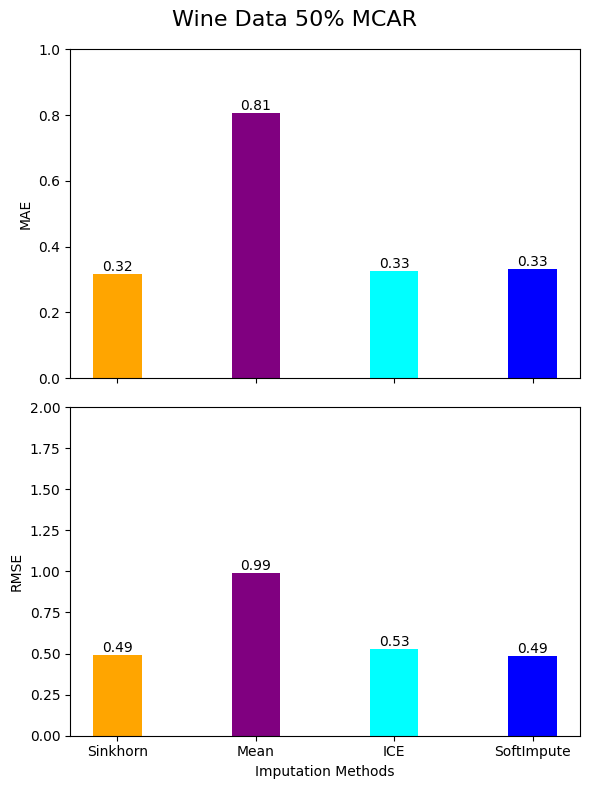

In [73]:

# Define values and categories
values_mae_mcar50 = [sk_mae_mcar50, mean_mae_mcar50, ice_mae_mcar50, soft_mae_mcar50]
values_rmse_mcar50 = [sk_rmse_mcar50, mean_rmse_mcar50, ice_rmse_mcar50, soft_rmse_mcar50]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Wine Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


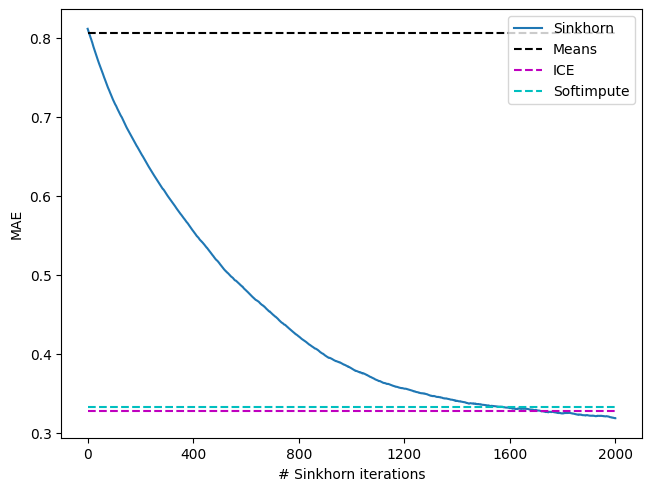

In [74]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

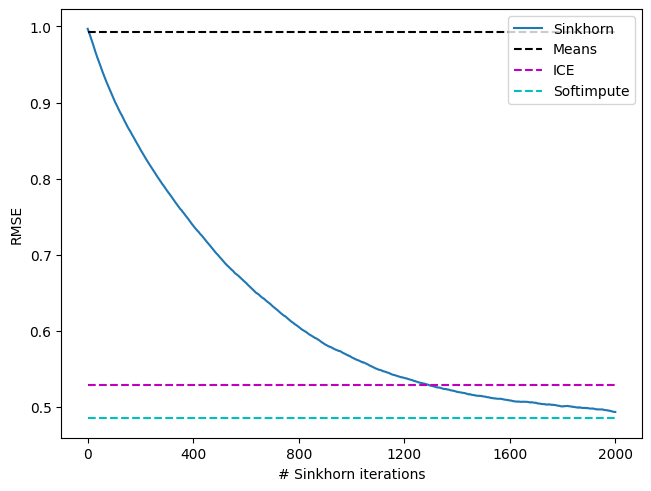

In [75]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

60% MCAR

In [76]:
#sinkhorn
n_mcar60, d_mcar60 = data_mcar60.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar60 = pick_epsilon(data_mcar60)

print(epsilon_mcar60)

sk_imputer_mcar60 = SinkhornImputation(eps=epsilon_mcar60, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar60, sk_maes60mcar, sk_rmses60mcar = sk_imputer_mcar60.fit_transform(data_mcar60, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar60_numpy = sk_imp_mcar60.detach().cpu().numpy()

sk_mae_mcar60 = MAE(sk_imp_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
sk_rmse_mcar60 = RMSE(sk_imp_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(sk_mae_mcar60,sk_rmse_mcar60)

INFO:root:batchsize = 128, epsilon = 0.1020
INFO:root:Iteration 0:	 Loss: 0.7669	 Validation MAE: 0.8116	RMSE: 0.9963


0.10204928213186731


INFO:root:Iteration 500:	 Loss: 0.4854	 Validation MAE: 0.5662	RMSE: 0.7463
INFO:root:Iteration 1000:	 Loss: 0.3960	 Validation MAE: 0.4337	RMSE: 0.6177
INFO:root:Iteration 1500:	 Loss: 2.2900	 Validation MAE: 0.3765	RMSE: 0.5632


0.3545703537916458 0.5380638582107418


In [77]:
#mean
#using numpy version of data
mean_imp_mcar60 = SimpleImputer().fit_transform(data_mcar60_numpy)
mean_mae_mcar60 = MAE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
mean_rmse_mcar60= RMSE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(mean_mae_mcar60, mean_rmse_mcar60)

#ICE
ice_imp_mcar60 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar60_numpy)
ice_mae_mcar60 = MAE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
ice_rmse_mcar60 = RMSE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(ice_mae_mcar60,ice_rmse_mcar60)

#SoftImpute
cv_error_mcar60, grid_lambda_mcar60 = cv_softimpute(data_mcar60_numpy, grid_len=15)
lbda_mcar60 = grid_lambda_mcar60[np.argmin(cv_error_mcar60)]
soft_imp_mcar60 = softimpute((data_mcar60_numpy), lbda_mcar60)[1]

soft_mae_mcar60 = MAE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
soft_rmse_mcar60 = RMSE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(soft_mae_mcar60,soft_rmse_mcar60)

0.8057435154966054 0.9900655950728751
0.40357096835038253 0.5882755225642138
0.37089047413045806 0.5335767935214312


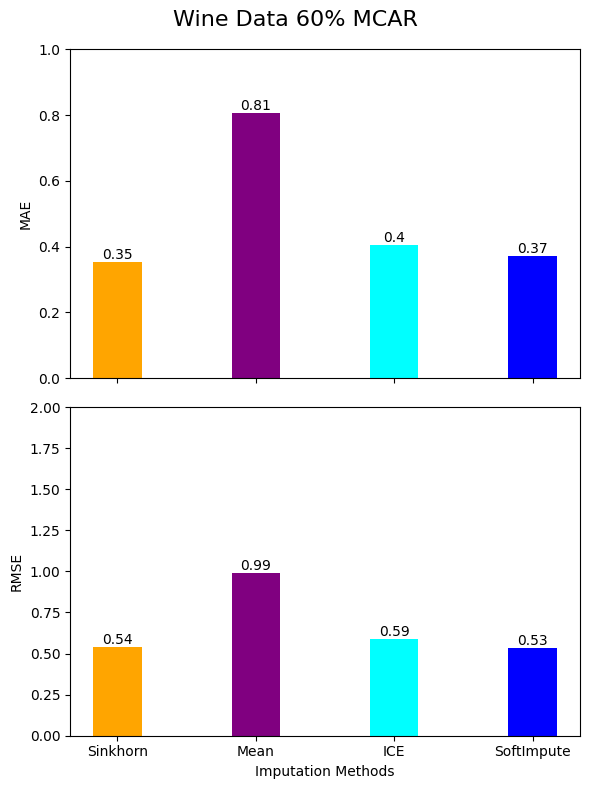

In [78]:

# Define values and categories
values_mae_mcar60 = [sk_mae_mcar60, mean_mae_mcar60, ice_mae_mcar60, soft_mae_mcar60]
values_rmse_mcar60 = [sk_rmse_mcar60, mean_rmse_mcar60, ice_rmse_mcar60, soft_rmse_mcar60]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Wine Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


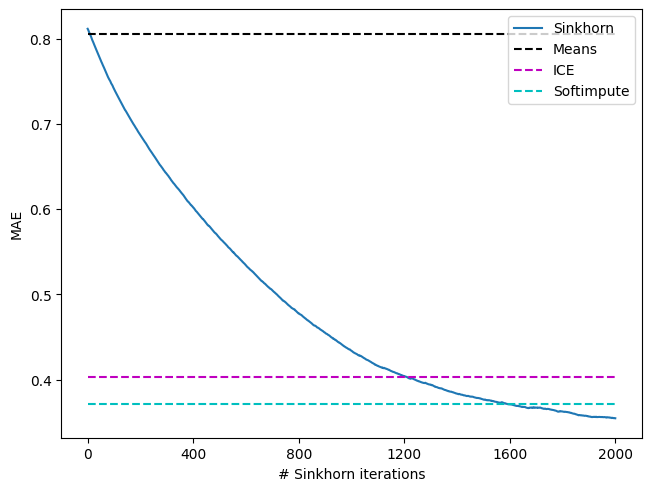

In [79]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

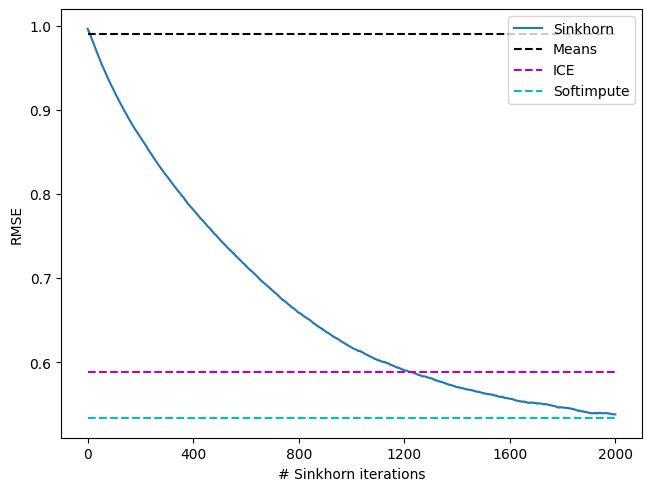

In [80]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

70% MCAR

In [81]:
#sinkhorn
n_mcar70, d_mcar70 = data_mcar70.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar70 = pick_epsilon(data_mcar70)

print(epsilon_mcar70)

sk_imputer_mcar70 = SinkhornImputation(eps=epsilon_mcar70, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar70, sk_maes70mcar, sk_rmses70mcar = sk_imputer_mcar70.fit_transform(data_mcar70, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar70_numpy = sk_imp_mcar70.detach().cpu().numpy()

sk_mae_mcar70 = MAE(sk_imp_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
sk_rmse_mcar70 = RMSE(sk_imp_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(sk_mae_mcar70,sk_rmse_mcar70)

INFO:root:batchsize = 128, epsilon = 0.0779


0.07788064078757229


INFO:root:Iteration 0:	 Loss: 0.6912	 Validation MAE: 0.8110	RMSE: 1.0052
INFO:root:Iteration 500:	 Loss: 0.3473	 Validation MAE: 0.6165	RMSE: 0.8081
INFO:root:Iteration 1000:	 Loss: 0.2948	 Validation MAE: 0.5012	RMSE: 0.6996
INFO:root:Iteration 1500:	 Loss: 0.2518	 Validation MAE: 0.4387	RMSE: 0.6468


0.41034752027745425 0.6211785582978678


In [82]:
#mean
#using numpy version of data
mean_imp_mcar70 = SimpleImputer().fit_transform(data_mcar70_numpy)
mean_mae_mcar70 = MAE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
mean_rmse_mcar70= RMSE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(mean_mae_mcar70, mean_rmse_mcar70)

#ICE
ice_imp_mcar70 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar70_numpy)
ice_mae_mcar70 = MAE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
ice_rmse_mcar70 = RMSE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(ice_mae_mcar70,ice_rmse_mcar70)

#SoftImpute
cv_error_mcar70, grid_lambda_mcar70 = cv_softimpute(data_mcar70_numpy, grid_len=15)
lbda_mcar70 = grid_lambda_mcar70[np.argmin(cv_error_mcar70)]
soft_imp_mcar70 = softimpute((data_mcar70_numpy), lbda_mcar70)[1]

soft_mae_mcar70 = MAE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
soft_rmse_mcar70 = RMSE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(soft_mae_mcar70,soft_rmse_mcar70)

0.8070667608111658 1.0013234525246915
0.45333109469021055 0.6450068304110664
0.4049355285066221 0.5887180580420318


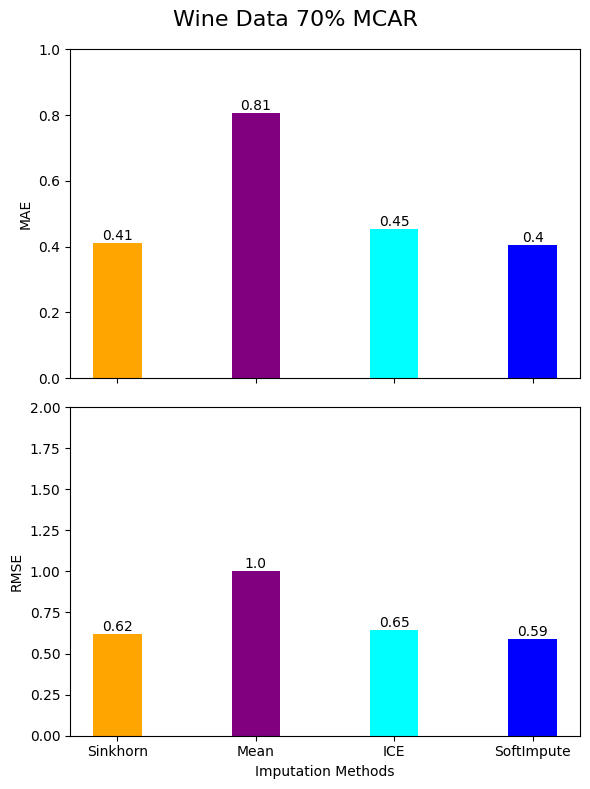

In [83]:

# Define values and categories
values_mae_mcar70 = [sk_mae_mcar70, mean_mae_mcar70, ice_mae_mcar70, soft_mae_mcar70]
values_rmse_mcar70 = [sk_rmse_mcar70, mean_rmse_mcar70, ice_rmse_mcar70, soft_rmse_mcar70]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Wine Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


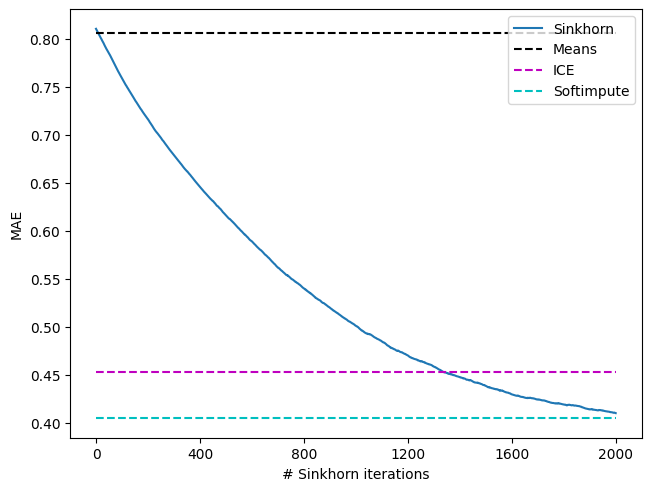

In [84]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

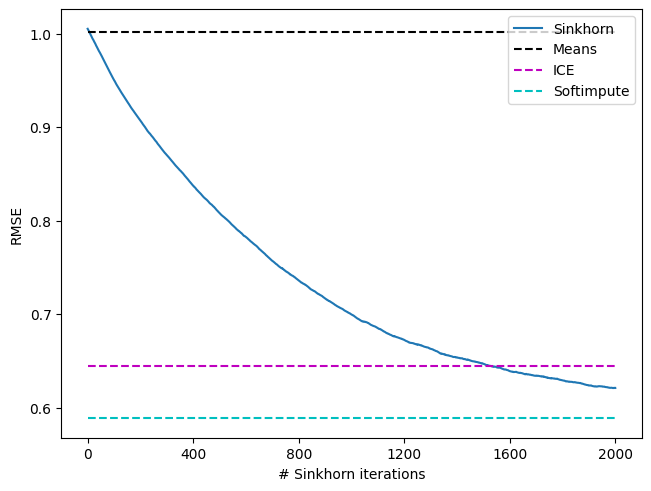

In [85]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

80% MCAR

In [86]:
#sinkhorn
n_mcar80, d_mcar80 = data_mcar80.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar80 = pick_epsilon(data_mcar80)

print(epsilon_mcar80)

sk_imputer_mcar80 = SinkhornImputation(eps=epsilon_mcar80, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar80, sk_maes80mcar, sk_rmses80mcar = sk_imputer_mcar80.fit_transform(data_mcar80, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar80_numpy = sk_imp_mcar80.detach().cpu().numpy()

sk_mae_mcar80 = MAE(sk_imp_mcar80_numpy,ground_truth_numpy ,mask_mcar80)
sk_rmse_mcar80 = RMSE(sk_imp_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(sk_mae_mcar80,sk_rmse_mcar80)

INFO:root:batchsize = 128, epsilon = 0.0502
INFO:root:Iteration 0:	 Loss: 0.3689	 Validation MAE: 0.8115	RMSE: 1.0057


0.050178737511234243


INFO:root:Iteration 500:	 Loss: 0.2883	 Validation MAE: 0.6821	RMSE: 0.8738
INFO:root:Iteration 1000:	 Loss: 0.2361	 Validation MAE: 0.5984	RMSE: 0.7960
INFO:root:Iteration 1500:	 Loss: 0.1635	 Validation MAE: 0.5444	RMSE: 0.7528


0.5156797081394466 0.7326737906648902


In [87]:
#mean
#using numpy version of data
mean_imp_mcar80 = SimpleImputer().fit_transform(data_mcar80_numpy)
mean_mae_mcar80 = MAE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
mean_rmse_mcar80= RMSE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(mean_mae_mcar80, mean_rmse_mcar80)

#ICE
ice_imp_mcar80 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar80_numpy)
ice_mae_mcar80 = MAE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
ice_rmse_mcar80 = RMSE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(ice_mae_mcar80,ice_rmse_mcar80)

#SoftImpute
cv_error_mcar80, grid_lambda_mcar80 = cv_softimpute(data_mcar80_numpy, grid_len=15)
lbda_mcar80 = grid_lambda_mcar80[np.argmin(cv_error_mcar80)]
soft_imp_mcar80 = softimpute((data_mcar80_numpy), lbda_mcar80)[1]

soft_mae_mcar80 = MAE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
soft_rmse_mcar80 = RMSE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(soft_mae_mcar80,soft_rmse_mcar80)

0.807402050162481 1.0012115271892437
0.7204210737038307 0.920292420650687
0.4843714097631472 0.6792306017956948


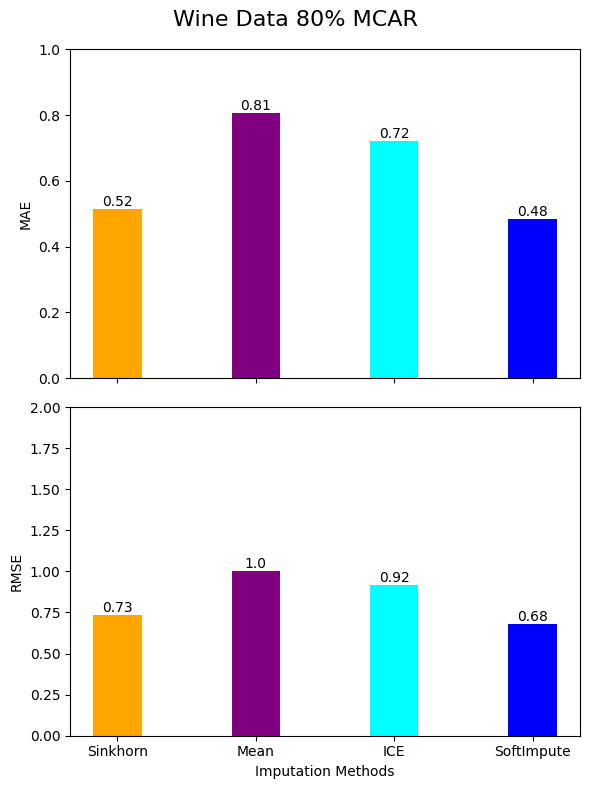

In [88]:

# Define values and categories
values_mae_mcar80 = [sk_mae_mcar80, mean_mae_mcar80, ice_mae_mcar80, soft_mae_mcar80]
values_rmse_mcar80 = [sk_rmse_mcar80, mean_rmse_mcar80, ice_rmse_mcar80, soft_rmse_mcar80]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Wine Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


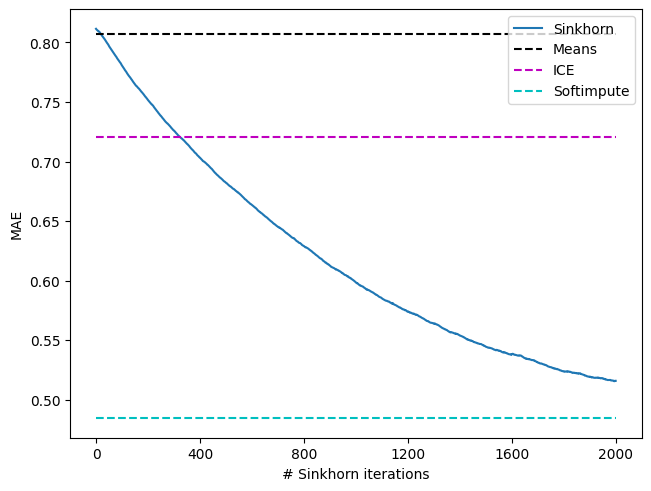

In [89]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

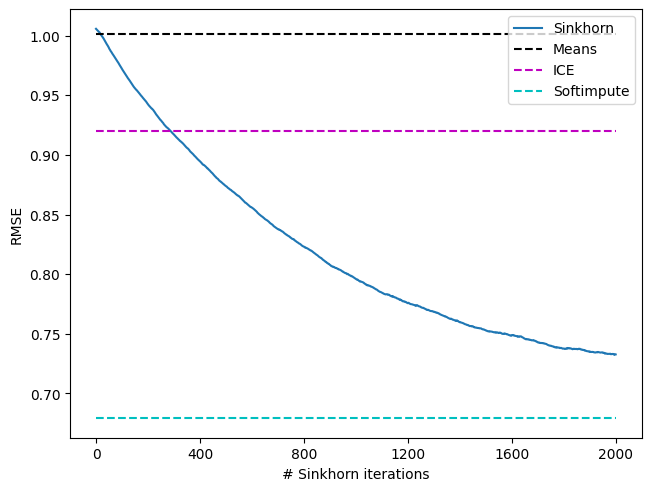

In [90]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

90% MCAR

In [91]:
#sinkhorn
n_mcar90, d_mcar90 = data_mcar90.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar90 = pick_epsilon(data_mcar90)

print(epsilon_mcar90)

sk_imputer_mcar90 = SinkhornImputation(eps=epsilon_mcar90, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar90, sk_maes90mcar, sk_rmses90mcar = sk_imputer_mcar90.fit_transform(data_mcar90, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar90_numpy = sk_imp_mcar90.detach().cpu().numpy()

sk_mae_mcar90 = MAE(sk_imp_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
sk_rmse_mcar90 = RMSE(sk_imp_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(sk_mae_mcar90,sk_rmse_mcar90)

INFO:root:batchsize = 128, epsilon = 0.0301


0.03014611369279714


INFO:root:Iteration 0:	 Loss: 0.2437	 Validation MAE: 0.8130	RMSE: 1.0065
INFO:root:Iteration 500:	 Loss: 0.1878	 Validation MAE: 0.7553	RMSE: 0.9487
INFO:root:Iteration 1000:	 Loss: 0.1775	 Validation MAE: 0.7168	RMSE: 0.9166
INFO:root:Iteration 1500:	 Loss: 0.2211	 Validation MAE: 0.6865	RMSE: 0.8935


0.6673702446869023 0.8826505506368829


In [92]:
#mean
#using numpy version of data
mean_imp_mcar90 = SimpleImputer().fit_transform(data_mcar90_numpy)
mean_mae_mcar90 = MAE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
mean_rmse_mcar90= RMSE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(mean_mae_mcar90, mean_rmse_mcar90)

#ICE
ice_imp_mcar90 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar90_numpy)
ice_mae_mcar90 = MAE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
ice_rmse_mcar90 = RMSE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(ice_mae_mcar90,ice_rmse_mcar90)

#SoftImpute
cv_error_mcar90, grid_lambda_mcar90 = cv_softimpute(data_mcar90_numpy, grid_len=15)
lbda_mcar90 = grid_lambda_mcar90[np.argmin(cv_error_mcar90)]
soft_imp_mcar90 = softimpute((data_mcar90_numpy), lbda_mcar90)[1]

soft_mae_mcar90 = MAE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
soft_rmse_mcar90 = RMSE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(soft_mae_mcar90,soft_rmse_mcar90)

0.8078596990864251 1.0006996334994325
0.7713027705985797 0.9669295495631997
0.6109317093778395 0.8143310051045513


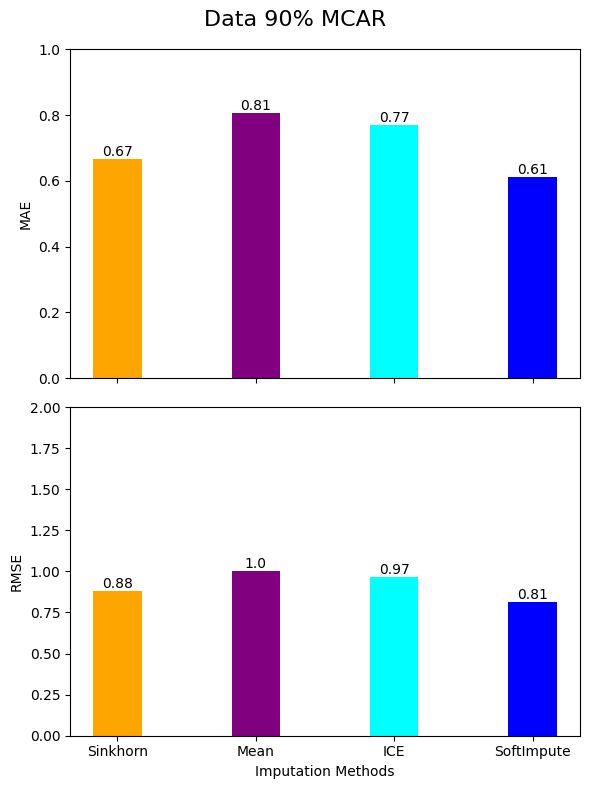

In [93]:

# Define values and categories
values_mae_mcar90 = [sk_mae_mcar90, mean_mae_mcar90, ice_mae_mcar90, soft_mae_mcar90]
values_rmse_mcar90 = [sk_rmse_mcar90, mean_rmse_mcar90, ice_rmse_mcar90, soft_rmse_mcar90]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


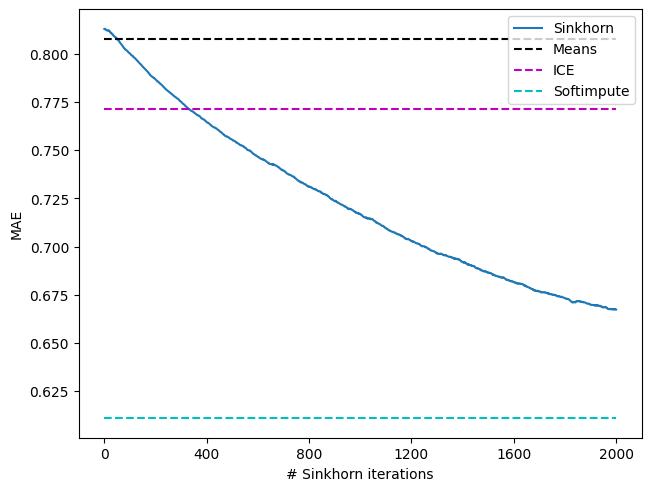

In [94]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

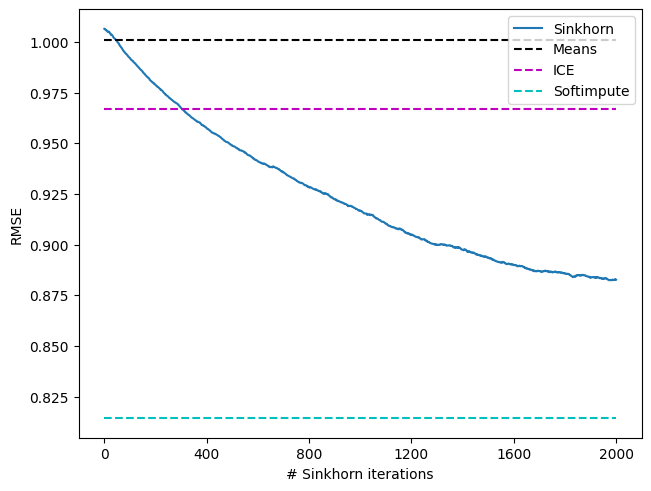

In [95]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

95% MCAR

In [96]:
#sinkhorn
n_mcar95, d_mcar95 = data_mcar95.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar95 = pick_epsilon(data_mcar95)

print(epsilon_mcar95)

sk_imputer_mcar95 = SinkhornImputation(eps=epsilon_mcar95, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar95, sk_maes95mcar, sk_rmses95mcar = sk_imputer_mcar95.fit_transform(data_mcar95, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar95_numpy = sk_imp_mcar95.detach().cpu().numpy()

sk_mae_mcar95 = MAE(sk_imp_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
sk_rmse_mcar95 = RMSE(sk_imp_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(sk_mae_mcar95,sk_rmse_mcar95)

INFO:root:batchsize = 128, epsilon = 0.0228
INFO:root:Iteration 0:	 Loss: 0.1422	 Validation MAE: 0.8121	RMSE: 1.0063


0.022789984609814934


INFO:root:Iteration 500:	 Loss: 0.0652	 Validation MAE: 0.7958	RMSE: 0.9911
INFO:root:Iteration 1000:	 Loss: 0.0901	 Validation MAE: 0.7879	RMSE: 0.9868
INFO:root:Iteration 1500:	 Loss: 0.0932	 Validation MAE: 0.7799	RMSE: 0.9828


0.7756783782737366 0.9816443978166367


In [97]:
#mean
#using numpy version of data
mean_imp_mcar95 = SimpleImputer().fit_transform(data_mcar95_numpy)
mean_mae_mcar95 = MAE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
mean_rmse_mcar95 = RMSE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(mean_mae_mcar95, mean_rmse_mcar95)

#ICE
ice_imp_mcar95 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar95_numpy)
ice_mae_mcar95 = MAE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
ice_rmse_mcar95 = RMSE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(ice_mae_mcar95,ice_rmse_mcar95)

#SoftImpute
cv_error_mcar95, grid_lambda_mcar95 = cv_softimpute(data_mcar95_numpy, grid_len=15)
lbda_mcar95 = grid_lambda_mcar95[np.argmin(cv_error_mcar95)]
soft_imp_mcar95 = softimpute((data_mcar95_numpy), lbda_mcar95)[1]

soft_mae_mcar95 = MAE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
soft_rmse_mcar95 = RMSE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(soft_mae_mcar95,soft_rmse_mcar95)

0.8063929427468675 1.0008591398197315
0.7880369081132139 0.984340871627051
0.6991734975864579 0.9019988778871851


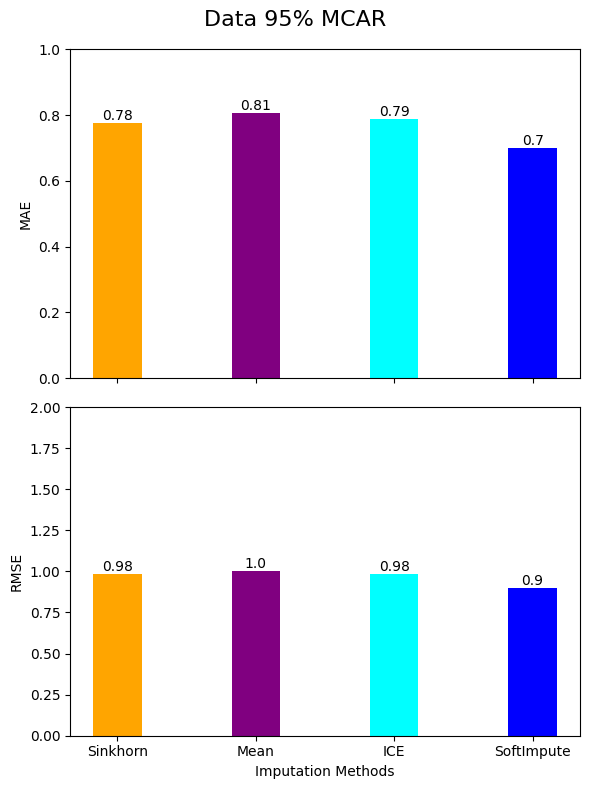

In [98]:

# Define values and categories
values_mae_mcar95 = [sk_mae_mcar95, mean_mae_mcar95, ice_mae_mcar95, soft_mae_mcar95]
values_rmse_mcar95 = [sk_rmse_mcar95, mean_rmse_mcar95, ice_rmse_mcar95, soft_rmse_mcar95]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


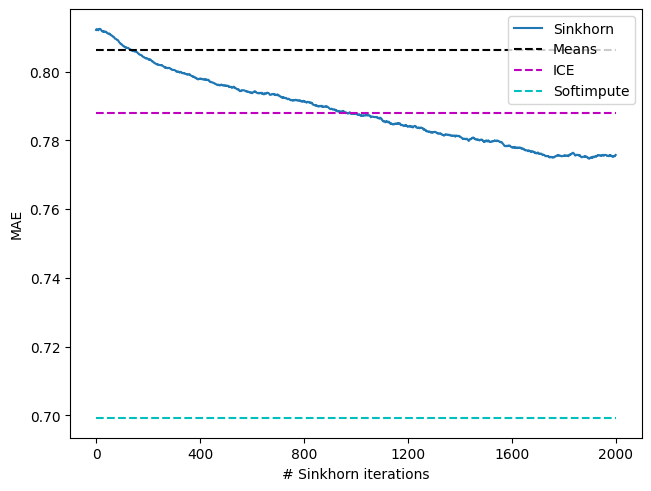

In [99]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

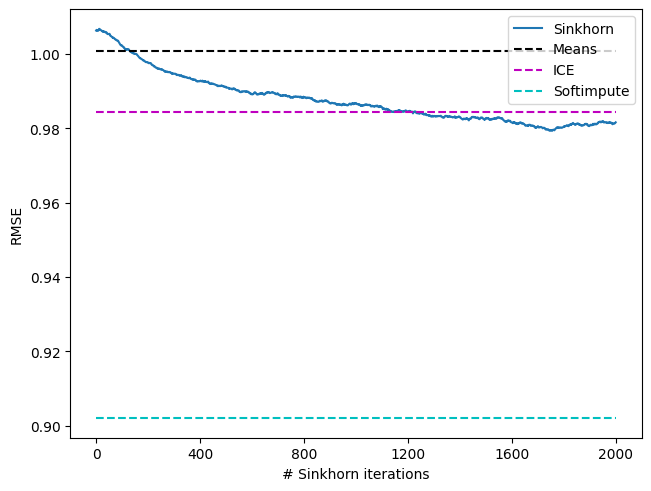

In [100]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

100% MCAR

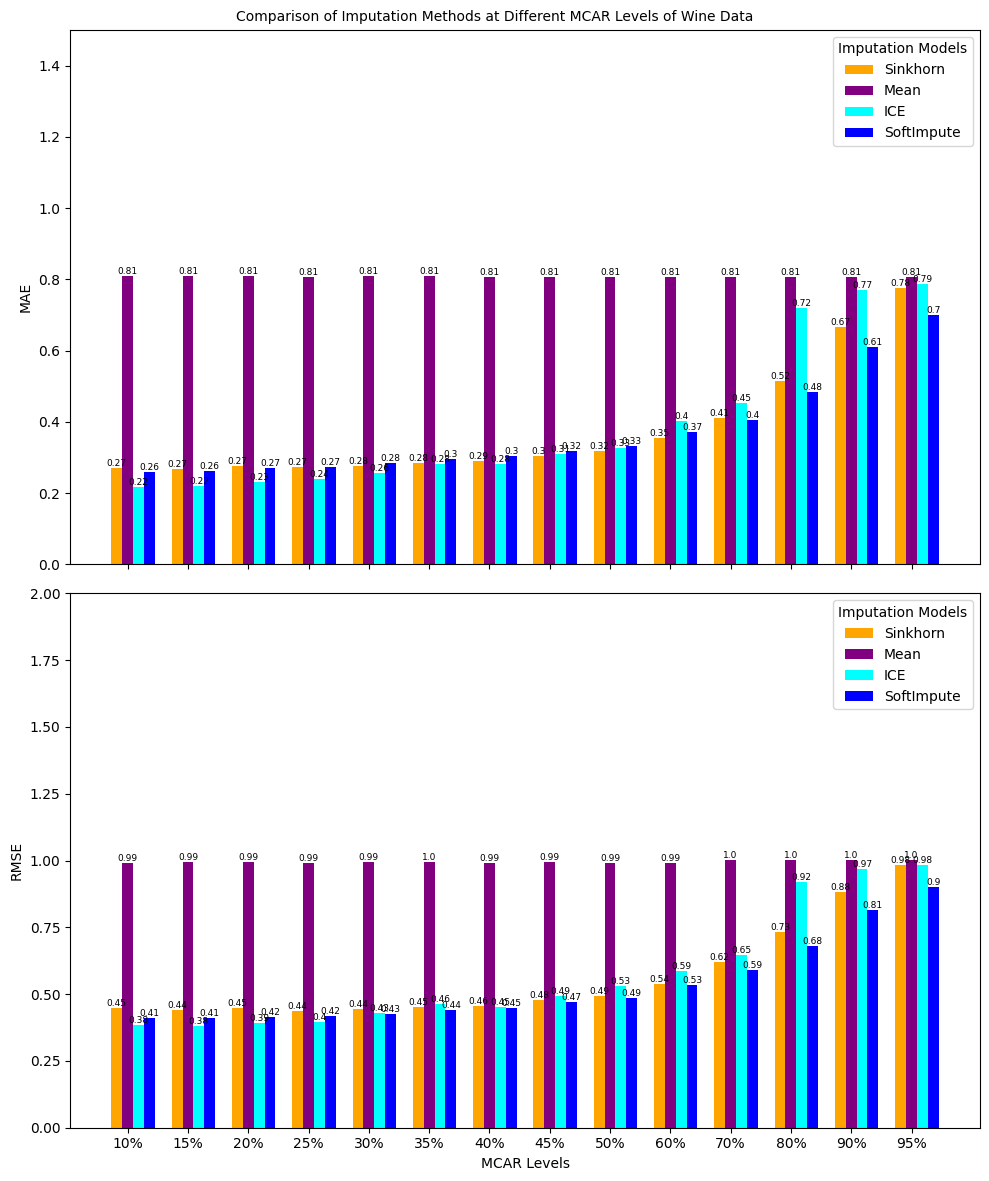

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30,sk_mae_mcar35,sk_mae_mcar40,sk_mae_mcar45,sk_mae_mcar50,sk_mae_mcar60,sk_mae_mcar70,sk_mae_mcar80,sk_mae_mcar90,sk_mae_mcar95]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30,mean_mae_mcar35,mean_mae_mcar40,mean_mae_mcar45,mean_mae_mcar50,mean_mae_mcar60,mean_mae_mcar70,mean_mae_mcar80,mean_mae_mcar90,mean_mae_mcar95]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30,ice_mae_mcar35,ice_mae_mcar40,ice_mae_mcar45,ice_mae_mcar50,ice_mae_mcar60,ice_mae_mcar70,ice_mae_mcar80,ice_mae_mcar90,ice_mae_mcar95]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30,soft_mae_mcar35,soft_mae_mcar40,soft_mae_mcar45,soft_mae_mcar50,soft_mae_mcar60,soft_mae_mcar70,soft_mae_mcar80,soft_mae_mcar90,soft_mae_mcar95]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30,sk_rmse_mcar35,sk_rmse_mcar40,sk_rmse_mcar45,sk_rmse_mcar50,sk_rmse_mcar60,sk_rmse_mcar70,sk_rmse_mcar80,sk_rmse_mcar90,sk_rmse_mcar95]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30,mean_rmse_mcar35,mean_rmse_mcar40,mean_rmse_mcar45,mean_rmse_mcar50,mean_rmse_mcar60,mean_rmse_mcar70,mean_rmse_mcar80,mean_rmse_mcar90,mean_rmse_mcar95]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30,ice_rmse_mcar35,ice_rmse_mcar40,ice_rmse_mcar45,ice_rmse_mcar50,ice_rmse_mcar60,ice_rmse_mcar70,ice_rmse_mcar80,ice_rmse_mcar90,ice_rmse_mcar95]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30,soft_rmse_mcar35,soft_rmse_mcar40,soft_rmse_mcar45,soft_rmse_mcar50,soft_rmse_mcar60,soft_rmse_mcar70,soft_rmse_mcar80,soft_rmse_mcar90,soft_rmse_mcar95]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10%', '15%', '20%', '25%', '30%','35%','40%','45%','50%','60%','70%','80%','90%','95%']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.18  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of Wine Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()
